<a href="https://colab.research.google.com/github/shatakshispace/shatakshispace/blob/main/Copy_of_Deep_fake_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
for dirname, _, filenames in os.walk("/content/drive/MyDrive/DEEP_LEARNING_PROJECT"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
!pip install dlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import dlib
import cv2
import os
import re
import json
from pylab import *
from PIL import Image, ImageChops, ImageEnhance


In [ ]:
# os.mkdir('/content/drive/MyDrive/dataset_dlp')
# os.mkdir('/content/drive/MyDrive/dataset_dlp/real')
# os.mkdir('/content/drive/MyDrive/dataset_dlp/fake')


In [ ]:
train_frame_folder = '/content/drive/MyDrive/DEEP_LEARNING_PROJECT/Deep Learning Project/train_sample_videos'
with open(os.path.join(train_frame_folder, 'metadata.json'), 'r') as file:
    data = json.load(file)
list_of_train_data = [f for f in os.listdir(train_frame_folder) if f.endswith('.mp4')]
detector = dlib.get_frontal_face_detector()
for vid in list_of_train_data:
    count = 0
    real=0
    fake=0
    cap = cv2.VideoCapture(os.path.join(train_frame_folder, vid))
    frameRate = cap.get(5)
    while cap.isOpened():
        frameId = cap.get(1)
        ret, frame = cap.read()
        if ret != True:
            break
        if frameId % ((int(frameRate)+1)*1) == 0:
            face_rects, scores, idx = detector.run(frame, 0)
            for i, d in enumerate(face_rects):
                x1 = d.left()
                y1 = d.top()
                x2 = d.right()
                y2 = d.bottom()
                crop_img = frame[y1:y2, x1:x2]
                if data[vid]['label'] == 'REAL':
                    cv2.imwrite('/content/drive/MyDrive/dataset_dlp/real/'+vid.split('.')[0]+'_'+str(count)+'.png', cv2.resize(crop_img, (128, 128)))
                    real+=1
                elif data[vid]['label'] == 'FAKE':
                    cv2.imwrite('/content/drive/MyDrive/dataset_dlp/fake/'+vid.split('.')[0]+'_'+str(count)+'.png', cv2.resize(crop_img, (128, 128)))
                    fake+=1
                count+=1

FileNotFoundError: ignored

In [ ]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
input_shape = (128, 128, 3)
data_dir = '/content/drive/MyDrive/dataset_dlp'

real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.png')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.png')]

X = []
Y = []

for img in real_data:
    X.append(img_to_array(load_img(data_dir+'/real/'+img)).flatten() / 255.0)
    Y.append(1)
for img in fake_data:
    X.append(img_to_array(load_img(data_dir+'/fake/'+img)).flatten() / 255.0)
    Y.append(0)

Y_val_org = Y

#Normalization
X = np.array(X)
Y = to_categorical(Y, 2)

#Reshape
X = X.reshape(-1, 128, 128, 3)

#Train-Test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [ ]:
print(Y_train)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


InceptionResnetV2 ::::

This function returns a Keras image classification model, optionally loaded with weights pre-trained on ImageNet.

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

googleNet_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
googleNet_model.trainable = True
model = Sequential()
model.add(googleNet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=2, activation='softmax'))

from tensorflow.keras.optimizers import legacy

model.compile(loss='binary_crossentropy',
              optimizer=legacy.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])

#model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_3   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 2)                 3074      
                                                                 
Total params: 54,339,810
Trainable params: 54,279,266
Non-trainable params: 60,544
_________________________________________________________________


**include_top=False**   here it means that last layer is not included that becomes the output

 use .Trainable=False when using the embedding layer in Keras to prevent the weights from being updated during training

Adam optimiser  Arguments

**learning_rate**: A Tensor, floating point value, or a schedule that is a tf.keras.optimizers.schedules.LearningRateSchedule, or a callable that takes no arguments and returns the actual value to use, The learning rate. Defaults to 0.001.

**beta_1**: A float value or a constant float tensor, or a callable that takes no arguments and returns the actual value to use. The exponential decay rate for the 1st moment estimates. Defaults to 0.9.

**beta_2**: A float value or a constant float tensor, or a callable that takes no arguments and returns the actual value to use, The exponential decay rate for the 2nd moment estimates. Defaults to 0.999.

**epsilon**: A small constant for numerical stability. This epsilon is "epsilon hat" in the Kingma and Ba paper (in the formula just before Section 2.1), not the epsilon in Algorithm 1 of the paper. Defaults to 1e-7.
amsgrad: Boolean. Whether to apply AMSGrad variant of this algorithm from the paper "On the Convergence of Adam and beyond". Defaults to False.
name: Optional name for the operations created when applying gradients. Defaults to "Adam".

**kwargs **bold text**: keyword arguments. Allowed arguments are clipvalue, clipnorm, global_clipnorm. If clipvalue (float) is set, the gradient of each weight is clipped to be no higher than this value. If clipnorm (float) is set, the gradient of each weight is individually clipped so that its norm is no higher than this value. If global_clipnorm (float) is set the gradient of all weights is clipped so that their global norm is no higher than this value.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=3,
                               verbose=0, mode='auto')
EPOCHS = 25
BATCH_SIZE = 100
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val, Y_val), verbose = 1)

Epoch 1/25
22/22 [==============================] - 55s 1s/step - loss: 0.7511 - accuracy: 0.3793 - val_loss: 0.9963 - val_accuracy: 0.2358
Epoch 2/25
22/22 [==============================] - 12s 552ms/step - loss: 0.6525 - accuracy: 0.5914 - val_loss: 0.8832 - val_accuracy: 0.2870
Epoch 3/25
22/22 [==============================] - 12s 554ms/step - loss: 0.5693 - accuracy: 0.7441 - val_loss: 0.8539 - val_accuracy: 0.3218
Epoch 4/25
22/22 [==============================] - 12s 546ms/step - loss: 0.4916 - accuracy: 0.8236 - val_loss: 0.8309 - val_accuracy: 0.3766
Epoch 5/25
22/22 [==============================] - 11s 518ms/step - loss: 0.4145 - accuracy: 0.8720 - val_loss: 0.8260 - val_accuracy: 0.4040
Epoch 6/25
22/22 [==============================] - 12s 540ms/step - loss: 0.3477 - accuracy: 0.9068 - val_loss: 0.8153 - val_accuracy: 0.4296
Epoch 7/25
22/22 [==============================] - 11s 518ms/step - loss: 0.2927 - accuracy: 0.9273 - val_loss: 0.8041 - val_accuracy: 0.4570
Ep

***EARLY_STOPPING*** Assuming the goal of a training is to minimize the loss. With this, the metric to be monitored would be 'loss', and mode would be 'min'. A model.fit() training loop will check at end of every epoch whether the loss is no longer decreasing, considering the min_delta and patience if applicable. Once it's found no longer decreasing, model.stop_training is marked True and the training terminates.

The quantity to be monitored needs to be available in logs dict. To make it so, pass the loss or metrics at model.compile().

Arguments

**monitor**: Quantity to be monitored.
min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.

**patience**: Number of epochs with no improvement after which training will be stopped.

**verbose**: Verbosity mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action.

**mode**: One of {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
baseline: Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline


**restore_best_weights**: Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used. An epoch will be restored regardless of the performance relative to the baseline. If no epoch improves on baseline, training will run for patience epochs and restore weights from the best epoch in that set.

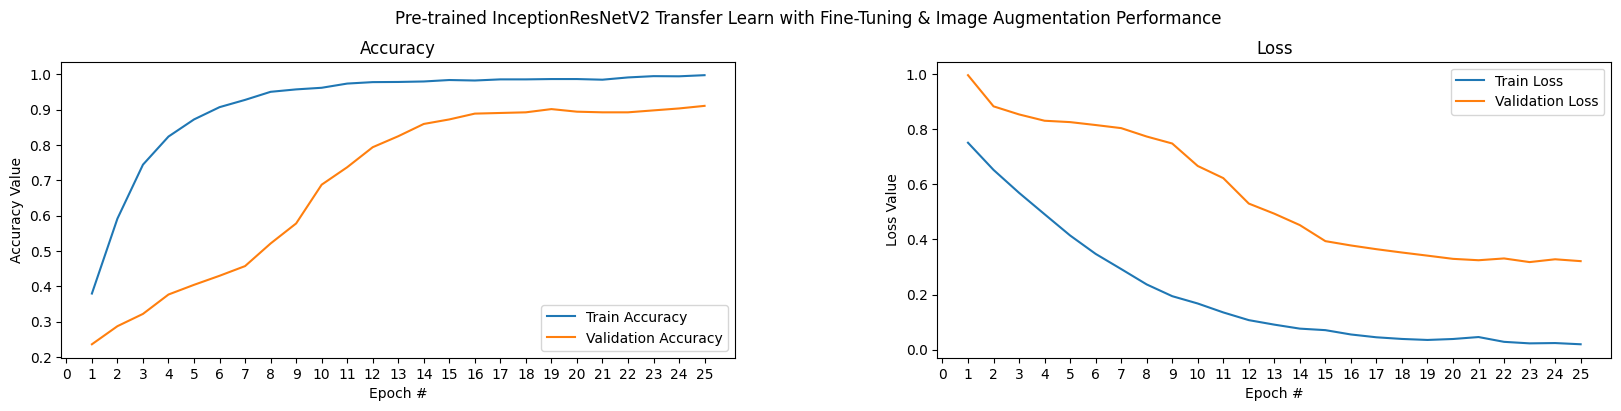

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained InceptionResNetV2 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

86/86 [==============================] - 14s 64ms/step
True positive =  2227
False positive =  14
False negative =  38
True negative =  456




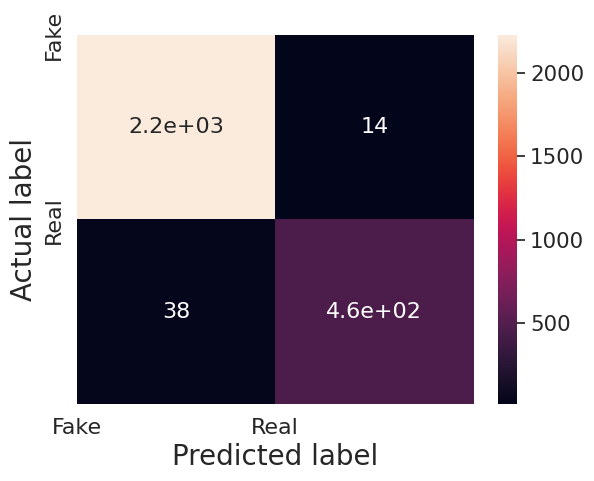

In [ ]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()

print_confusion_matrix(Y_val_org, np.argmax(model.predict(X), axis=-1))

In [ ]:
model.save('deepfake-detection-model.h5')

In [ ]:
import tensorflow as tf
import dlib
import cv2
import os
import numpy as np
from PIL import Image, ImageChops, ImageEnhance
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [ ]:
tf.__version__


'2.8.2'

In [ ]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Append the folder and file name to the current directory
model_path = os.path.join(current_dir, 'saved_models', 'my_model.h5')

# Print the model path
print(model_path)

/content/saved_models/my_model.h5


In [ ]:
model = load_model('deepfake-detection-model.h5')

In [ ]:
input_shape = (128, 128, 3)
pr_data = []
detector = dlib.get_frontal_face_detector()
cap = cv2.VideoCapture('/content/drive/MyDrive/DEEP_LEARNING_PROJECT/Deep Learning Project/test_videos')
frameRate = cap.get(5)
while cap.isOpened():
    frameId = cap.get(1)
    ret, frame = cap.read()
    if ret != True:
        break
    if frameId % ((int(frameRate)+1)*1) == 0:
        face_rects, scores, idx = detector.run(frame, 0)
        for i, d in enumerate(face_rects):
            x1 = d.left()
            y1 = d.top()
            x2 = d.right()
            y2 = d.bottom()
            crop_img = frame[y1:y2, x1:x2]
            data = img_to_array(cv2.resize(crop_img, (128, 128))).flatten() / 255.0
            data = data.reshape(-1, 128, 128, 3)
            print(model.predict_classes(data))

In [ ]:
import sklearn.metrics
cm = sklearn.metrics.accuracy_score(Y_val_org, np.argmax(model.predict(X), axis=-1))

In [ ]:
print(cm)

0.976502002670227


In [ ]:
!pip install flask pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=708505aa761f481c3de8d78a708dbb2c3ab66ec1c929e62d5a9b6a206350fd71
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok


In [ ]:
!pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install flask gunicorn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.9 MB/s eta 0:00:00


In [ ]:
if __name__ == '__main__':
    app.run()









 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [ ]:
!curl https://cli-assets.heroku.com/install.sh | sh




  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1926  100  1926    0     0  15532      0 --:--:-- --:--:-- --:--:-- 15532
Installing CLI from https://cli-assets.heroku.com/channels/stable/heroku-linux-x64.tar.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35.7M  100 35.7M    0     0  6084k      0  0:00:06  0:00:06 --:--:-- 5333k
v16.19.0
heroku installed to /usr/local/bin/heroku
 ›   Warning: Our terms of service have changed: 
 ›   https://dashboard.heroku.com/terms-of-service
heroku/8.1.9 linux-x64 node-v16.19.0


In [ ]:

heroku login






heroku: Press any key to open up the browser to login or q to exit: ^C
